In [2]:
from typing import Tuple, List, Dict
from pathlib import Path

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import tqdm
tqdm.tqdm.pandas()

from joblib import Parallel, delayed

from scipy.stats import norm

import vectorbt as vbt


In [3]:
from market_data import MarketData

# Parameters

In [4]:
start_date = '2017-01-01'

In [5]:
analysis_dir = Path('analysis')

# Pair Selection

In [6]:
pair_df = pd.read_csv(analysis_dir / 'pairs.csv')
pair_df

,left_symbol,right_symbol,cointegration,cointegration_test_period,correlation,left_companyName,left_sector,left_industry,right_companyName,right_sector,right_industry,same_sector,same_industry,alpha,beta,left_half_life,right_half_life,spread_half_life,left_hurst,right_hurst,left_VaR,left_CVaR,right_VaR,right_CVaR
0,ICE,ZBRA,0.999990,4267,0.921816,"Intercontinental Exchange, Inc.",Financial Services,Financial Data & Stock Exchanges,Zebra Technologies Corporation,Technology,Communication Equipment,False,False,-0.307507,1.246738,-4171.347385,-15206.826017,547.383064,0.422320,0.544870,-0.032960,-0.058654,-0.033591,-0.054747
1,JNPR,TPR,0.999990,5551,-0.123542,"Juniper Networks, Inc.",Technology,Communication Equipment,"Tapestry, Inc.",Consumer Cyclical,Luxury Goods,False,False,2.893194,0.140865,463.511463,3794.351841,1176.724157,0.528819,0.499346,-0.049623,-0.077658,-0.038379,-0.062078
2,MBI,LULU,0.999989,3843,-0.027899,MBIA Inc.,Financial Services,Insurance—Specialty,Lululemon Athletica Inc.,Consumer Cyclical,Apparel Retail,False,False,2.896420,0.563837,1972.747682,-2752.406489,910.641747,0.511336,0.438883,-0.048364,-0.084237,-0.044949,-0.073931
3,EBAY,LSI,0.999989,6065,0.914633,eBay Inc.,Consumer Cyclical,Internet Retail,"Life Storage, Inc.",Real Estate,REIT—Industrial,False,False,1.496467,0.739130,29832.125027,-2830.423523,1121.945354,0.494545,0.429923,-0.040757,-0.069210,-0.024821,-0.042188
4,JPM,WTW,0.999989,5381,0.948272,JPMorgan Chase & Co.,Financial Services,Banks—Diversified,Willis Towers Watson Public Limited Company,Financial Services,Insurance Brokers,True,False,2.095041,0.652963,-13438.627734,-4997.649075,699.759923,0.478669,0.377684,-0.034680,-0.054405,-0.023175,-0.038785
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22530,BWA,LBTYK,0.950007,4316,0.875707,BorgWarner Inc.,Consumer Cyclical,Auto Parts,Liberty Global plc,Communication Services,Telecom Services,False,False,-0.179080,0.947352,8348.932040,5960.763182,657.721274,0.475160,0.451980,-0.034694,-0.052044,-0.030287,-0.049510
22531,LIN,SO,0.950006,6248,0.923458,Linde plc,Basic Materials,Specialty Chemicals,The Southern Company,Utilities,Utilities—Regulated Electric,False,False,1.562967,0.467798,-2129.422834,-6322.536823,704.915707,0.394240,0.361833,-0.026850,-0.039937,-0.019140,-0.030212
22532,KR,PPG,0.950005,6248,0.901057,The Kroger Co.,Consumer Defensive,Grocery Stores,"PPG Industries, Inc.",Basic Materials,Specialty Chemicals,False,False,0.882089,1.095208,-4207.621220,-16711.488530,8431.579082,0.442471,0.479466,-0.027641,-0.044010,-0.027124,-0.040719
22533,DHI,ETSY,0.950004,1900,0.925374,"D.R. Horton, Inc.",Consumer Cyclical,Residential Construction,"Etsy, Inc.",Consumer Cyclical,Internet Retail,True,False,-5.481609,2.388161,-5170.915493,1319.830553,797.320137,0.461235,0.532347,-0.042125,-0.063906,-0.056610,-0.086710


In [7]:
selected_pair_df = pair_df[
    (pair_df['cointegration'] > 0.95)
    # & (pair_df['correlation'] > 0.90)
    # Average Spread
    & ((pair_df['spread_half_life'] > 0) & (pair_df['spread_half_life'] < 252))
    & ((pair_df[['left_CVaR', 'right_CVaR']] > -0.1).all(axis=1))
    # & ((pair_df['left_hurst'] < 0.4) & (pair_df['right_hurst'] < 0.4))
]
selected_pair_df

,left_symbol,right_symbol,cointegration,cointegration_test_period,correlation,left_companyName,left_sector,left_industry,right_companyName,right_sector,right_industry,same_sector,same_industry,alpha,beta,left_half_life,right_half_life,spread_half_life,left_hurst,right_hurst,left_VaR,left_CVaR,right_VaR,right_CVaR
18,LSXMA,LSXMK,0.999987,1647,0.998782,The Liberty SiriusXM Group,Communication Services,Broadcasting,The Liberty SiriusXM Group,Communication Services,Broadcasting,True,True,-0.055785,1.014518,-159222.496791,-41078.133834,5.907756,0.432876,0.436685,-0.026235,-0.045873,-0.026279,-0.046276
143,BKNG,LSXMK,0.999959,1647,0.862565,Booking Holdings Inc.,Consumer Cyclical,Travel Services,The Liberty SiriusXM Group,Communication Services,Broadcasting,False,False,-1.810703,0.730387,49648.063651,-41078.133834,125.595781,0.362293,0.436685,-0.051282,-0.090748,-0.026279,-0.046276
151,ICE,TTWO,0.999958,4267,0.956829,"Intercontinental Exchange, Inc.",Financial Services,Financial Data & Stock Exchanges,"Take-Two Interactive Software, Inc.",Communication Services,Electronic Gaming & Multimedia,False,False,-1.561609,1.367735,-4171.347385,-43546.866519,238.844213,0.422320,0.459971,-0.032960,-0.058654,-0.045430,-0.074226
163,GOOGL,STE,0.999956,4582,0.978620,Alphabet Inc.,Communication Services,Internet Content & Information,STERIS plc,Healthcare,Medical Devices,False,False,1.444649,0.795622,-3136.532795,-3551.796183,239.648860,0.473351,0.359884,-0.028370,-0.043380,-0.031358,-0.050849
177,CCI,EQIX,0.999951,5590,0.972993,Crown Castle Inc.,Real Estate,REIT—Specialty,"Equinix, Inc.",Real Estate,REIT—Specialty,True,True,0.462317,1.160233,-10356.194271,7426.209567,231.529535,0.356932,0.421101,-0.041981,-0.068874,-0.047933,-0.087321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22402,ZTS,CIEN,0.950354,2454,0.949325,Zoetis Inc.,Healthcare,Drug Manufacturers—Specialty & Generic,Ciena Corporation,Technology,Communication Equipment,False,False,0.722014,0.618353,-2640.185967,260.131580,201.903094,0.460535,0.428151,-0.023942,-0.035218,-0.057493,-0.094998
22411,TXT,BHF,0.950328,1333,0.660522,Textron Inc.,Industrials,Aerospace & Defense,"Brighthouse Financial, Inc.",Financial Services,Insurance—Life,False,False,0.938194,0.705383,49697.530302,1041.469250,178.645066,0.514856,0.358933,-0.034462,-0.058882,-0.048439,-0.075294
22451,AMCR,SIRI,0.950233,2633,0.589659,Amcor plc,Consumer Cyclical,Packaging & Containers,Sirius XM Holdings Inc.,Communication Services,Entertainment,False,False,-2.145311,1.578078,-27446.453669,512.631001,164.184156,0.410399,0.488687,-0.022563,-0.038406,-0.060086,-0.099416
22454,CHRW,SEDG,0.950216,1914,0.736041,"C.H. Robinson Worldwide, Inc.",Industrials,Integrated Freight & Logistics,"SolarEdge Technologies, Inc.",Technology,Solar,False,False,-18.526830,5.143101,-11207.821427,2030.805019,181.831152,0.385537,0.328918,-0.029926,-0.047543,-0.057787,-0.086121


# Market Data

In [8]:
market_data = MarketData('dataset')
symbols = pd.concat([selected_pair_df['left_symbol'], selected_pair_df['right_symbol']]).unique()
price_df = market_data.read_batch(symbols)
price_df = price_df.loc[start_date:]
price_df

100%|██████████| 350/350 [00:03<00:00, 106.50it/s]


,LSXMA,BKNG,ICE,GOOGL,CCI,GOOG,DE,AMZN,NTRS,NLOK,DRI,AMT,PM,EPAM,APTV,STR,ARE,EXPD,CL,HSIC,NSC,CTLT,LOW,EW,IR,ECL,HD,AIZ,VICI,CBOE,SYK,TDG,AMCR,BDX,ZTS,GNW,GM,PKI,GPN,NWSA,PCAR,MCO,TFC,IQV,MCHP,LH,ADSK,ALLE,DELL,MTB,NWS,D,GL,DUK,DPZ,COO,CHD,MBI,DHI,IBM,AVY,PEG,CRL,CZR,CDW,M,OKE,CBRE,SPGI,LW,HPE,KEYS,EXPE,SPG,PAYC,ZBH,GILD,ANSS,INVH,CPRT,FBHS,KSS,HCA,CSX,PSX,PPG,AXP,TECH,WHR,ROP,WU,ADBE,IDXX,ADI,STE,HOLX,NDSN,MDLZ,ACN,LMT,BBY,KMB,OI,STZ,HUM,AKAM,MPC,WDC,MMM,CFG,PNC,PPL,TDY,DFS,AVGO,FCX,WTW,EMR,ALL,KMX,DLR,MRK,FANG,SNA,CPRI,KMI,AMD,JEF,LYB,MA,NRG,THC,GRMN,ATVI,ETSY,RE,KEY,APH,ODFL,FMC,MET,BIIB,CMA,AMAT,LUMN,BHF,FLT,NYT,SHW,TWTR,JBHT,WRK,FIS,LYV,EVRG,SYF,ORLY,AZN,FTV,NOW,PKG,JKHY,EIX,EBAY,ULTA,PFG,WBA,DISH,MDT,APD,CHRW,UNP,V,LBTYK,BATRK,HBAN,WDAY,LDOS,TJX,IEX,OMC,ZION,HLT,AES,LULU,QRVO,HOG,BATRA,TDC,ANET,RTX,COST,CHTR,ALK,VRSK,RL,LNT,BK,SGEN,ALGN,FRT,FLS,GLW,HSY,AWK,DOV,SLG,INCY,PH,HAS,TXN,DVA,HRL,ROST,MNST,ROK,JNPR,DTE,FDX,CNP,ITW,SEDG,CTAS,ISRG,PNR,XLNX,MCD,EFX,FWONK,IFF,UHS,MAR,COF,AEP,FLR,LEN,HRB,JWN,TXT,LSXMK,TTWO,EQIX,ON,LHX,RMD,SE,BC,PTEN,INFO,JD,NVR,OKTA,SANM,POOL,SIRI,TEAM,WEC,FLEX,LILAK,TSLA,TMO,MELI,INFY,SII,TEL,MLM,JBL,NEE,TER,LSI,VRSN,DGX,YUM,VMC,PENN,RNWK,MRVL,CIEN,LRCX,WAT,ORCL,CNXT,CAG,GME,XYL,PANW,MPWR,NTES,NVDA,INTU,GNRC,PLD,VIAV,FHN,AN,AIV,WB,MGM,EA,HIG,HII,SLM,JNJ,ASND,GWW,BB,LILA,EL,CRUS,PBCT,NAVI,SWN,ROL,SPLK,PHM,HST,TFX,ASML,SJM,CHKP,CLF,TGNA,MMI,ADTN,GNTX,CSGP,QGEN,FTNT,MAA,NFLX,QCOM,WM,HON,KLAC,CNX,NXPI,TEVA,FWONA,MOH,ES,EYE,ANF,TGT,IAC,J,FSLR,TCOM,WST,RAD,BMRN
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-03,33.9233,1477.569946,56.220001,40.400501,86.800003,39.306999,104.050003,37.683498,89.639999,24.010000,72.059998,106.150002,91.230003,63.66,56.613579,NaN,110.580002,53.099998,65.540001,61.1490,106.989998,27.00,70.949997,31.840000,NaN,118.040001,134.309998,94.120003,NaN,73.010002,119.430000,250.539993,10.63,161.121948,53.590000,3.87,35.150002,52.990002,70.500000,11.69,65.320000,95.470001,46.979999,76.93,31.924999,129.070007,76.18,64.699997,15.314722,156.740005,12.05,76.250000,73.919998,77.730003,158.360001,175.149994,44.340000,10.979999,27.559999,159.837479,70.139999,43.389999,76.53,17.049999,51.540001,35.229999,58.750000,31.570000,108.389999,37.490002,13.484004,36.28,112.440002,182.619995,46.47,100.320389,74.160004,93.349998,NaN,27.860001,53.889999,49.779999,74.459999,11.963333,86.790001,95.250000,75.349998,102.610001,182.929993,184.929993,21.969999,103.48,117.60,72.510002,68.220001,40.150002,113.419998,44.849998,116.459999,253.309998,42.759998,114.559998,17.950001,154.750000,197.610001,67.57,52.930000,69.430000,178.050003,35.860001,117.970001,34.029999,124.00,72.730003,178.339996,13.78,123.239998,56.950001,74.169998,64.820000,99.360001,57.395039,103.25,171.149994,43.08,21.610001,11.43,21.816479,86.879997,105.389999,12.30,15.40,49.189999,36.639999,11.88,216.039993,18.260000,33.715000,57.853333,49.462273,48.377895,291.709991,68.959999,31.940001,25.350000,NaN,144.649994,13.45,91.513336,16.44,96.769997,51.220001,76.980003,27.40,56.200001,37.060001,280.82,27.709999,44.962341,75.66,85.000000,88.889999,71.750000,29.840000,256.68,58.580002,82.959999,59.69,70.610001,143.399994,72.849998,102.519997,79.500000,29.80,20.64,13.320000,68.38,50.950001,37.724998,91.220001,85.070000,43.180000,56.204281,11.66,66.849998,52.900002,58.939999,20.50,27.580000,24.264999,69.748268,159.729996,285.769989,88.000000,81.320000,90.629997,37.930000,47.959999,53.00,96.959999,143.399994,49.009998,24.299999,103.919998,72.250000,61.728596,115.228218,102.320000,142.550003,79.800003,73.580002,65.09,35.290001,65.610001,45.540001,138.539993,28.600000,83.582977,187.699997,24.590000,122.519997,13.20,116.320000,71.309998,38.918735,59

In [9]:
daily_expected_returns = price_df.pct_change().mean() 
annualized_expected_returns = (1 + daily_expected_returns)**252 - 1
annualized_expected_returns.sort_values(ascending=False)

GME     1.775842
SEDG    0.994425
STR     0.955656
TSLA    0.935441
ETSY    0.721697
          ...   
SLG    -0.097378
TEVA   -0.104479
LUMN   -0.110885
DISH   -0.120740
RAD    -0.232738
Length: 350, dtype: float64

# Backtesting

In [10]:
pair = selected_pair_df.iloc[0]

pair


left_symbol                                       LSXMA
right_symbol                                      LSXMK
cointegration                                  0.999987
cointegration_test_period                          1647
correlation                                    0.998782
left_companyName             The Liberty SiriusXM Group
left_sector                      Communication Services
left_industry                              Broadcasting
right_companyName            The Liberty SiriusXM Group
right_sector                     Communication Services
right_industry                             Broadcasting
same_sector                                        True
same_industry                                      True
alpha                                         -0.055785
beta                                           1.014518
left_half_life                           -159222.496791
right_half_life                           -41078.133834
spread_half_life                               5

In [11]:
def get_pair_price(pair: pd.Series, price_df: pd.DataFrame) -> Tuple[pd.Series]:

    left_symbol = pair['left_symbol']
    right_symbol = pair['right_symbol']

    left_price = price_df[left_symbol]
    right_price = price_df[right_symbol]

    start_date = max(left_price.first_valid_index(), right_price.first_valid_index())
    end_date = min(left_price.last_valid_index(), right_price.last_valid_index())

    left_price = left_price.loc[start_date: end_date]
    right_price = right_price.loc[start_date: end_date]

    return left_price, right_price

def calculate_spread(left_price: pd.Series, right_price: pd.Series, pair: pd.Series) -> Tuple[pd.Series, float]:
    spread = np.log(right_price) - (np.log(left_price) * pair['beta'] + pair['alpha']) # log spread
    return spread

def calculate_adjusted_price(price: pd.Series, alpha: float, beta: float) -> pd.Series:
    adjusted_price = np.exp(np.log(price) * beta + alpha)
    return adjusted_price

def generate_constant_boundary(spread: pd.Series, confidence: float) -> Tuple[float, float]:
    mu, sigma = spread.mean(), spread.std()
    lower_bound = norm.ppf(confidence, loc=mu, scale=sigma)
    upper_bound = norm.ppf(1 - confidence, loc=mu, scale=sigma)
    return lower_bound, upper_bound

In [12]:
def calculate_pair_allocation(beta: float) -> Tuple[float, float]:
    left_allocation = 1 / (np.exp(beta) + 1)
    right_allocation = 1 - left_allocation
    return left_allocation, right_allocation

In [13]:
def cross_up(a: pd.Series, b: pd.Series) -> pd.Series:
    return (a > b) & (a.shift(1) <= b.shift(1))
def cross_down(a: pd.Series, b: pd.Series) -> pd.Series:
    return (a < b) & (a.shift(1) >= b.shift(1))

def simulate_pair_trading(
        spread: pd.Series, 
        left_price: pd.Series,
        right_price: pd.Series,
        lower_bound: float, 
        upper_bound: float, 
        left_allocation: float,
        right_allocation: float,
        capital: float = 100_000,
) -> Tuple[vbt.Portfolio, vbt.Portfolio]:
    lower_bound_line = pd.Series(np.full_like(spread, lower_bound), index=spread.index)
    upper_bound_line = pd.Series(np.full_like(spread, upper_bound), index=spread.index)
    zero_line = pd.Series(np.full_like(spread, 0), index=spread.index)

    # Long pair
    long_pair_entry = cross_up(spread, lower_bound_line)
    # long_pair_exit = cross_up(spread, upper_bound_line)
    long_pair_exit = cross_up(spread, zero_line)

    # Short pair
    short_pair_entry = cross_down(spread, upper_bound_line)
    # short_pair_exit = cross_down(spread, lower_bound_line)
    short_pair_exit = cross_down(spread, zero_line)

    left_long_entry = short_pair_entry
    left_long_exit = short_pair_exit

    right_long_entry = long_pair_entry
    right_long_exit = long_pair_exit

    left_short_entry = long_pair_entry
    left_short_exit = long_pair_exit

    right_short_entry = short_pair_entry
    right_short_exit = short_pair_exit

    left_portfolio = vbt.Portfolio.from_signals(
        left_price,
        entries=left_long_entry,
        exits=left_long_exit,
        short_entries=left_short_entry,
        short_exits=left_short_exit,
        init_cash=capital*left_allocation,
        freq='D',
        fees=0.001,
    )
    right_portfolio = vbt.Portfolio.from_signals(
        right_price,
        entries=right_long_entry,
        exits=right_long_exit,
        short_entries=right_short_entry,
        short_exits=right_short_exit,
        init_cash=capital*right_allocation,
        freq='D',
        fees=0.001,
    )

    return left_portfolio, right_portfolio

In [14]:
def create_buy_and_hold(prices: pd.Series, capital: float) -> pd.Series:
    return capital / prices.iloc[0] * prices

In [15]:
def evaluate_performance(prices: pd.Series) -> dict:
    prices = prices.dropna()
    total_return = (prices.iloc[-1] / prices.iloc[0] - 1)
    annualized_return = (1 + total_return) ** (252 / len(prices)) - 1

    returns = prices.pct_change()
    annualized_volatility = returns.std() * np.sqrt(252)

    peak = prices.cummax()
    drawdown = (peak - prices) / peak

    max_drawdown = drawdown.max()
    sharpe_ratio = annualized_return / annualized_volatility
    calmar_ratio = annualized_return / max_drawdown
    sortino_ratio = annualized_return / (returns[returns < 0].std() * np.sqrt(252))

    return {
        'Total Return': total_return,
        'Annualized Return': annualized_return,
        'Annualized Volatility': annualized_volatility,
        'Max Drawdown': max_drawdown,
        'Sharpe Ratio': sharpe_ratio,
        'Calmar Ratio': calmar_ratio,
        'Sortino Ratio': sortino_ratio,
    }

def evaluate_pair_trade(
        left_portfolio: vbt.Portfolio,
        right_portfolio: vbt.Portfolio,
) -> dict:
    with pd.option_context('mode.chained_assignment', None):

        left_trade_df = left_portfolio.trades.records.set_index('id')
        right_trade_df = right_portfolio.trades.records.set_index('id')
        left_trade_df['principal'] = left_trade_df['size'] * left_trade_df['entry_price'] - left_trade_df['entry_fees']
        right_trade_df['principal'] = right_trade_df['size'] * right_trade_df['entry_price'] - right_trade_df['entry_fees']

        trade_df = left_trade_df[['entry_idx', 'exit_idx']]

        trade_df[['left_principal', 'left_pnl', 'left_direction']] = left_trade_df[['principal', 'pnl', 'direction']]
        trade_df[['right_principal', 'right_pnl', 'right_direction']] = right_trade_df[['principal', 'pnl', 'direction']]
        trade_df['principal'] = trade_df['left_principal'] + trade_df['right_principal']
        trade_df['pair_direction'] = np.where(trade_df['right_direction'] == 1, 'long', 'short')
        trade_df['pnl'] = trade_df['left_pnl'] + trade_df['right_pnl']
        trade_df['return'] = trade_df['pnl'] / trade_df['principal']

        dates = left_portfolio.value().index
        trade_df['duration'] = dates[trade_df['exit_idx']] - dates[trade_df['entry_idx']]
    win_count = (trade_df['pnl'] > 0).sum()
    loss_count = (trade_df['pnl'] < 0).sum()
    total_trade = win_count + loss_count
    win_rate = win_count / total_trade

    avg_win_return = trade_df[trade_df['pnl'] > 0]['return'].mean()
    avg_loss_return = trade_df[trade_df['pnl'] < 0]['return'].mean()

    avg_win_duration = trade_df[trade_df['pnl'] > 0]['duration'].mean().days
    avg_loss_duration = trade_df[trade_df['pnl'] < 0]['duration'].mean().days
    total_trade_duration = trade_df['duration'].sum().days
    avg_trade_per_year = total_trade / ((dates[-1] - dates[0]).days) * 252
    avg_trade_duration_per_year = total_trade_duration / ((dates[-1] - dates[0]).days) * 252

    return {
        'Total Trade': total_trade,
        'Win Count': win_count,
        'Loss Count': loss_count,
        'Avg Trade per Year': avg_trade_per_year,
        'Win Rate [%]': win_rate * 100,
        'Avg Winning per Trade [%]': avg_win_return * 100,
        'Avg Losing per Trade [%]': avg_loss_return * 100,
        'Avg Winning Duration [days]': avg_win_duration,
        'Avg Losing Duration [days]': avg_loss_duration,
        'Total Trade Duration [days]': total_trade_duration,
        'Avg Trade Duration per Year [days]': avg_trade_duration_per_year,
    }

In [16]:
def plot_summary(
        left_nav: pd.Series,
        right_nav: pd.Series,
        nav: pd.Series,
        benchmark_nav: pd.Series,
        left_symbol: str,
        right_symbol: str,
        adjusted_left_price: pd.Series,
        right_price: pd.Series,
        spread: pd.Series,
        lower_bound: float,
        upper_bound: float,
        output_path: str 
):
    fig = make_subplots(rows=3, cols=1, shared_xaxes=True, vertical_spacing=0.03)
    # NAV plot
    fig.add_trace(
        go.Scatter(
            x=nav.index,
            y=left_nav,
            name=left_symbol,
            legendgroup='1'
        ),
        row=1, col=1
    )

    fig.add_trace(
        go.Scatter(
            x=nav.index,
            y=right_nav,
            name=right_symbol,
            legendgroup='1'
        ),
        row=1, col=1
    )

    fig.add_trace(
        go.Scatter(
            x=nav.index,
            y=nav,
            name='NAV',
            legendgroup='1'
        ),
        row=1, col=1
    )

    fig.add_trace(
        go.Scatter(
            x=benchmark_nav.index,
            y=benchmark_nav,
            name='Benchmark',
            legendgroup='1',
            line=dict(color='grey', dash='dash')
        ),
    )


    # Price plot
    fig.add_trace(
        go.Scatter(
            x=adjusted_left_price.index,
            y=adjusted_left_price,
            name=left_symbol,
            legendgroup='2'
        ),
        row=2, col=1
    )

    fig.add_trace(
        go.Scatter(
            x=right_price.index,
            y=right_price,
            name=right_symbol,
            legendgroup='2'
        ),
        row=2, col=1
    )

    # Spread plot
    fig.add_trace(
        go.Scatter(
            x=spread.index, 
            y=spread, 
            name='Spread',

            legendgroup='3'
        ), 
        row=3, 
        col=1
    )
    fig.add_hline(y=0, line_dash='dot', row=3, col=1, line_color='grey')
    fig.add_hline(y=lower_bound, line_dash='dot', row=3, col=1, line_color='red')
    fig.add_hline(y=upper_bound, line_dash='dot', row=3, col=1, line_color='red')

    fig.update_layout(height=600, width=800, title_text="Summary Plot")
    fig.update_xaxes(showspikes = True) 
    fig.update_yaxes(showline=True)
    fig.update_layout(hovermode='x unified', spikedistance=-1) 
    fig.update_xaxes(spikemode='across+marker')

    fig.write_html(output_path)

In [17]:
def backtest(
        pair: pd.Series, 
        output_dir: str = None,
        confidence: float = 0.2, 
        capital: float = 100_000,

) -> pd.Series:
    confidence = 0.2
    capital = 100_000
    left_price, right_price = get_pair_price(pair, price_df)
    adjusted_left_price = calculate_adjusted_price(left_price, pair['alpha'], pair['beta'])
    spread = calculate_spread(left_price, right_price, pair)

    lower_bound, upper_bound = generate_constant_boundary(spread, confidence=confidence)

    left_allocation, right_allocation = calculate_pair_allocation(beta=pair['beta'])

    left_portfolio, right_portfolio = simulate_pair_trading(
        spread=spread,
        left_price=left_price,
        right_price=right_price,
        lower_bound=lower_bound,
        upper_bound=upper_bound,
        left_allocation=left_allocation,
        right_allocation=right_allocation,
        capital=capital,
    )

    left_nav = left_portfolio.value()
    right_nav = right_portfolio.value()
    nav = left_nav + right_nav

    left_buy_and_hold = create_buy_and_hold(left_price, capital=0.5 * capital)
    right_buy_and_hold = create_buy_and_hold(right_price, capital=0.5 * capital)
    benchmark_nav = left_buy_and_hold + right_buy_and_hold

    performance_stats = pd.Series(evaluate_performance(nav))
    benchmark_performance_stats = pd.Series(evaluate_performance(benchmark_nav))
    trade_stats = pd.Series(evaluate_pair_trade(left_portfolio, right_portfolio))

    if output_dir is not None:
        output_path = Path(output_dir) / f'{pair["left_symbol"]}_{pair["right_symbol"]}.html'
        plot_summary(
            left_nav=left_nav,
            right_nav=right_nav,
            nav=nav,
            benchmark_nav=benchmark_nav,
            left_symbol=pair['left_symbol'],
            right_symbol=pair['right_symbol'],
            adjusted_left_price=adjusted_left_price,
            right_price=right_price,
            spread=spread,
            lower_bound=lower_bound,
            upper_bound=upper_bound,
            output_path=str(output_path)
        )

    return pd.concat([
        pair, 
        performance_stats, 
        benchmark_performance_stats.add_prefix('Benchmark - '),
        trade_stats
    ])

# backtest_result_df = selected_pair_df.progress_apply(backtest, axis=1, output_dir='analysis/plot')
# backtest_result_df

In [18]:
# Parallel apply with progress bar

# from joblib import Parallel, delayed
# from tqdm import tqdm
func = delayed(backtest)
backtest_result_df = pd.DataFrame(
    Parallel(n_jobs=-1)(
        func(pair, output_dir=analysis_dir / 'plot')
        for _, pair in tqdm.tqdm(selected_pair_df.iterrows(), total=len(selected_pair_df))
    )
)

  6%|▌         | 32/528 [00:28<05:54,  1.40it/s]/var/folders/dr/syp1qtg16lb2mq85d1_56p2h0000gn/T/ipykernel_72027/1478440374.py:4: RuntimeWarning:

invalid value encountered in double_scalars

 29%|██▉       | 152/528 [00:41<00:42,  8.78it/s]/var/folders/dr/syp1qtg16lb2mq85d1_56p2h0000gn/T/ipykernel_72027/1478440374.py:4: RuntimeWarning:

invalid value encountered in double_scalars

 32%|███▏      | 168/528 [00:44<00:44,  8.02it/s]/var/folders/dr/syp1qtg16lb2mq85d1_56p2h0000gn/T/ipykernel_72027/1478440374.py:4: RuntimeWarning:

invalid value encountered in double_scalars

 36%|███▋      | 192/528 [00:48<00:51,  6.47it/s]/var/folders/dr/syp1qtg16lb2mq85d1_56p2h0000gn/T/ipykernel_72027/1478440374.py:4: RuntimeWarning:

invalid value encountered in double_scalars

 42%|████▏     | 224/528 [00:53<00:47,  6.42it/s]/var/folders/dr/syp1qtg16lb2mq85d1_56p2h0000gn/T/ipykernel_72027/1478440374.py:4: RuntimeWarning:

invalid value encountered in double_scalars

/var/folders/dr/syp1qtg16lb2mq85d1_5

In [19]:
backtest_result_df.sort_values('Total Trade', ascending=False)

,left_symbol,right_symbol,cointegration,cointegration_test_period,correlation,left_companyName,left_sector,left_industry,right_companyName,right_sector,right_industry,same_sector,same_industry,alpha,beta,left_half_life,right_half_life,spread_half_life,left_hurst,right_hurst,left_VaR,left_CVaR,right_VaR,right_CVaR,Total Return,Annualized Return,Annualized Volatility,Max Drawdown,Sharpe Ratio,Calmar Ratio,Sortino Ratio,Benchmark - Total Return,Benchmark - Annualized Return,Benchmark - Annualized Volatility,Benchmark - Max Drawdown,Benchmark - Sharpe Ratio,Benchmark - Calmar Ratio,Benchmark - Sortino Ratio,Total Trade,Win Count,Loss Count,Avg Trade per Year,Win Rate [%],Avg Winning per Trade [%],Avg Losing per Trade [%],Avg Winning Duration [days],Avg Losing Duration [days],Total Trade Duration [days],Avg Trade Duration per Year [days]
0,LSXMA,LSXMK,0.999987,1647,0.998782,The Liberty SiriusXM Group,Communication Services,Broadcasting,The Liberty SiriusXM Group,Communication Services,Broadcasting,True,True,-0.055785,1.014518,-159222.496791,-41078.133834,5.907756,0.432876,0.436685,-0.026235,-0.045873,-0.026279,-0.046276,-0.152518,-0.028027,0.094949,0.266197,-0.295175,-0.105285,-0.293095,0.266243,0.041383,0.319341,0.529168,0.129587,0.078203,0.152778,42.0,17.0,25.0,4.983051,40.476190,1.975280,-1.928826,18.0,26.0,990.0,117.457627
55,TFC,LSXMK,0.998689,1647,0.874729,Truist Financial Corporation,Financial Services,Banks—Regional,The Liberty SiriusXM Group,Communication Services,Broadcasting,False,False,0.862673,0.730942,5748.859151,-41078.133834,130.143647,0.441914,0.436685,-0.030675,-0.049608,-0.026279,-0.046276,1.975992,0.206035,0.172567,0.217536,1.193945,0.947130,1.436215,0.115457,0.018947,0.290504,0.521431,0.065220,0.036336,0.078547,33.0,26.0,7.0,3.915254,78.787879,5.804401,-4.695371,41.0,31.0,1292.0,153.288136
11,NTRS,LSXMA,0.999876,1647,0.876499,Northern Trust Corporation,Financial Services,Asset Management,The Liberty SiriusXM Group,Communication Services,Broadcasting,False,False,0.259424,0.755841,6337.382941,-159222.496791,151.770440,0.421053,0.432876,-0.031665,-0.049188,-0.026235,-0.045873,0.932989,0.119872,0.120065,0.124648,0.998388,0.961678,1.071467,0.102579,0.016916,0.276615,0.468363,0.061154,0.036117,0.072912,30.0,27.0,3.0,3.559322,90.000000,3.045618,-4.609618,30.0,26.0,904.0,107.254237
51,TFC,LSXMA,0.998797,1647,0.874822,Truist Financial Corporation,Financial Services,Banks—Regional,The Liberty SiriusXM Group,Communication Services,Broadcasting,False,False,0.908356,0.719697,5748.859151,-159222.496791,129.261029,0.441914,0.432876,-0.030675,-0.049608,-0.026235,-0.045873,2.280352,0.226378,0.180874,0.213995,1.251576,1.057866,1.477026,0.109705,0.018042,0.294507,0.527724,0.061262,0.034188,0.072960,30.0,24.0,6.0,3.559322,80.000000,5.943190,-2.733516,46.0,38.0,1355.0,160.762712
12,NTRS,LSXMK,0.999872,1647,0.876478,Northern Trust Corporation,Financial Services,Asset Management,The Liberty SiriusXM Group,Communication Services,Broadcasting,False,False,0.195159,0.769509,6337.382941,-41078.133834,141.047885,0.421053,0.436685,-0.031665,-0.049188,-0.026279,-0.046276,0.774176,0.103500,0.143016,0.181592,0.723699,0.569961,0.834017,0.108331,0.017825,0.274237,0.464658,0.065000,0.038363,0.077890,27.0,21.0,6.0,3.203390,77.777778,3.678351,-2.910123,36.0,43.0,1028.0,121.966102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,JEF,GME,0.986006,5215,0.580542,Jefferies Financial Group Inc.,Financial Services,Capital Markets,GameStop Corp.,Consumer Cyclical,Specialty Retail,False,False,-3.831473,1.810468,10110.309049,122.478184,118.705035,0.535862,0.284337,-0.031261,-0.051526,-0.050629,-0.088007,-1.991267,NaN,23.500310,3.952512,NaN,NaN,NaN,2.007524,0.208221,0.960116,0.803418,0.216871,0.259169,0.348015,2.0,1.0,1.0,0.237288,50.000000,818.658521,-110.896248,300.0,952.0,1252.0,148.542373
403,FBHS,GME,0

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Annualized Return Distribution')

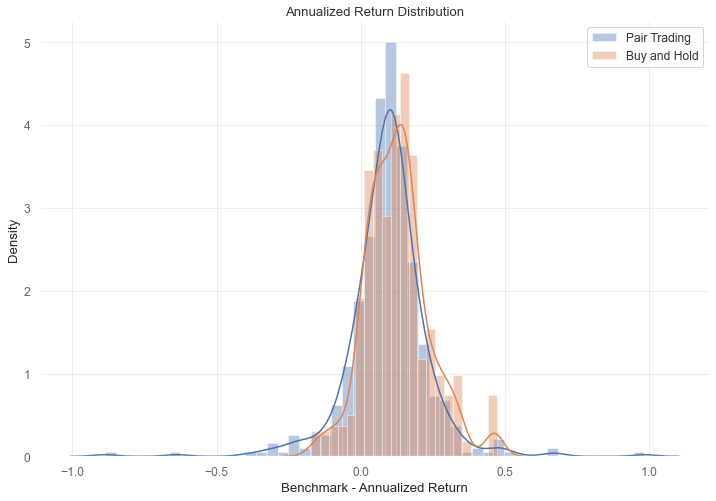

In [20]:


# Plot overlapping histogram
fig, ax = plt.subplots(figsize=(12, 8))
sns.distplot(backtest_result_df['Annualized Return'], label='Pair Trading', ax=ax)
sns.distplot(backtest_result_df['Benchmark - Annualized Return'], label='Buy and Hold', ax=ax)
ax.legend()
ax.set_title('Annualized Return Distribution')


In [21]:
backtest_result_df['Max Drawdown'].describe()

count    528.000000
mean       0.479010
std        0.562392
min        0.068454
25%        0.209235
50%        0.307980
75%        0.495456
max        4.309762
Name: Max Drawdown, dtype: float64

In [22]:
backtest_result_df[backtest_result_df['Max Drawdown'] > 1]

,left_symbol,right_symbol,cointegration,cointegration_test_period,correlation,left_companyName,left_sector,left_industry,right_companyName,right_sector,right_industry,same_sector,same_industry,alpha,beta,left_half_life,right_half_life,spread_half_life,left_hurst,right_hurst,left_VaR,left_CVaR,right_VaR,right_CVaR,Total Return,Annualized Return,Annualized Volatility,Max Drawdown,Sharpe Ratio,Calmar Ratio,Sortino Ratio,Benchmark - Total Return,Benchmark - Annualized Return,Benchmark - Annualized Volatility,Benchmark - Max Drawdown,Benchmark - Sharpe Ratio,Benchmark - Calmar Ratio,Benchmark - Sortino Ratio,Total Trade,Win Count,Loss Count,Avg Trade per Year,Win Rate [%],Avg Winning per Trade [%],Avg Losing per Trade [%],Avg Winning Duration [days],Avg Losing Duration [days],Total Trade Duration [days],Avg Trade Duration per Year [days]
25,CL,JD,0.999634,2126,0.781442,Colgate-Palmolive Company,Consumer Defensive,Household & Personal Products,"JD.com, Inc.",Consumer Cyclical,Internet Retail,False,False,-14.037179,4.145775,-8360.599401,1797.403626,159.246698,0.372340,0.448164,-0.020781,-0.033003,-0.045417,-0.063636,-1.021075,NaN,27.721355,1.282909,NaN,NaN,NaN,0.302576,0.046455,0.327135,0.528002,0.142007,0.087984,0.211644,17.0,11.0,6.0,2.016949,64.705882,10.992187,-20.850324,42.0,51.0,910.0,107.966102
36,GOOG,POOL,0.999293,4582,0.982240,Alphabet Inc.,Communication Services,Internet Content & Information,Pool Corporation,Industrials,Industrial Distribution,False,False,0.932261,1.012666,-3097.280067,-3968.334941,208.671630,0.474773,0.497391,-0.028181,-0.043446,-0.031133,-0.048662,-0.358738,-0.073484,7.569835,1.287873,-0.009708,-0.057059,-0.015683,1.751709,0.189911,0.261280,0.437476,0.726848,0.434107,0.908052,4.0,3.0,1.0,0.474576,75.000000,2.487867,-40.472568,73.0,1236.0,1455.0,172.627119
37,GOOGL,POOL,0.999263,4582,0.980756,Alphabet Inc.,Communication Services,Internet Content & Information,Pool Corporation,Industrials,Industrial Distribution,False,False,0.924880,1.012740,-3136.532795,-3968.334941,222.663130,0.473351,0.497391,-0.028370,-0.043380,-0.031133,-0.048662,-0.282427,-0.055416,7.691171,1.288802,-0.007205,-0.042998,-0.013895,1.714868,0.187159,0.261701,0.438011,0.715165,0.427294,0.890681,3.0,2.0,1.0,0.355932,66.666667,9.805045,-40.511933,195.0,1236.0,1626.0,192.915254
68,PCAR,MELI,0.998247,3833,0.812874,PACCAR Inc,Industrials,Farm & Heavy Construction Machinery,"MercadoLibre, Inc.",Consumer Cyclical,Internet Retail,False,False,-9.731422,3.666743,-5427.905255,2803.037012,174.136782,0.428273,0.485741,-0.032689,-0.050059,-0.051862,-0.080563,-0.999997,-0.887427,267.020726,1.662550,-0.003323,-0.533775,-0.111906,2.475154,0.238591,0.445133,0.631562,0.536000,0.377780,0.758564,9.0,3.0,6.0,1.067797,33.333333,12.344392,-29.851256,90.0,189.0,1574.0,186.745763
86,CZR,ETSY,0.996760,1900,0.904712,"Caesars Entertainment, Inc.",Consumer Cyclical,Resorts & Casinos,"Etsy, Inc.",Consumer Cyclical,Internet Retail,True,False,-0.609396,1.247693,2018.750558,1319.830553,230.726326,0.504261,0.532347,-0.049602,-0.086059,-0.056610,-0.086710,-0.870994,-0.296569,5.725723,2.054380,-0.051796,-0.144360,-0.060532,4.414046,0.336607,0.519235,0.737150,0.648275,0.456633,0.915099,2.0,2.0,0.0,0.237288,100.000000,134.336621,NaN,1398.0,NaN,2796.0,331.728814
114,FBHS,PENN,0.994120,2799,0.815336,"Fortune Brands Home & Security, Inc.",Industrials,Building Products & Equipment,"PENN Entertainment, Inc.",Consumer Cyclical,Resorts & Casinos,False,False,-1.948691,1.268693,-121775.592298,1149.306197,250.146862,0.510992,0.552635,-0.030103,-0.047213,-0.043514,-0.070946,1.668192,0.183628,11.821656,1.303258,0.015533,0.140899,0.008615,0.729684,0.098697,0.497456,0.754389,0.198403,0.130830,0.254899,5.0,5.0,0.0,0.593220,100.000000,22.790874,NaN,218.0,NaN,1093.0,129.677966
132,WU,GME,0.993047,4048,0.102958,The Western Union Company,Financial Services,Credit Services,GameStop Corp.,Consumer Cyclical,Specialty Retail,False,False,3.281436,-0.454870,2762.844529,122.478184,64.943250,0.492478,

In [23]:
backtest_result_df.sort_values('Max Drawdown', ascending=True)

,left_symbol,right_symbol,cointegration,cointegration_test_period,correlation,left_companyName,left_sector,left_industry,right_companyName,right_sector,right_industry,same_sector,same_industry,alpha,beta,left_half_life,right_half_life,spread_half_life,left_hurst,right_hurst,left_VaR,left_CVaR,right_VaR,right_CVaR,Total Return,Annualized Return,Annualized Volatility,Max Drawdown,Sharpe Ratio,Calmar Ratio,Sortino Ratio,Benchmark - Total Return,Benchmark - Annualized Return,Benchmark - Annualized Volatility,Benchmark - Max Drawdown,Benchmark - Sharpe Ratio,Benchmark - Calmar Ratio,Benchmark - Sortino Ratio,Total Trade,Win Count,Loss Count,Avg Trade per Year,Win Rate [%],Avg Winning per Trade [%],Avg Losing per Trade [%],Avg Winning Duration [days],Avg Losing Duration [days],Total Trade Duration [days],Avg Trade Duration per Year [days]
222,INVH,MDLZ,0.985652,1447,0.919368,Invitation Homes Inc.,Real Estate,REIT—Residential,"Mondelez International, Inc.",Consumer Defensive,Confectioners,False,False,1.827704,0.635607,-6206.031141,-11168.086051,196.666753,0.410614,0.406636,-0.023254,-0.039260,-0.020013,-0.032552,0.493432,0.072346,0.072594,0.068454,0.996591,1.056862,1.224610,0.503144,0.073557,0.213847,0.410717,0.343971,0.179095,0.410349,16.0,16.0,0.0,1.924582,100.000000,2.546182,NaN,60.0,NaN,970.0,116.677804
396,FTV,CHKP,0.964918,1594,0.689844,Fortive Corporation,Technology,Scientific & Technical Instruments,Check Point Software Technologies Ltd.,Technology,Software—Infrastructure,True,False,2.221665,0.605445,-258785.054945,86423.045815,160.098921,0.441134,0.428934,-0.025870,-0.042035,-0.042475,-0.071574,0.608559,0.085080,0.117919,0.096940,0.721506,0.877656,0.888490,0.469806,0.068395,0.222661,0.430598,0.307171,0.158837,0.393522,13.0,12.0,1.0,1.542373,92.307692,4.416385,-3.681736,84.0,88.0,1097.0,130.152542
73,IR,MLM,0.998035,1377,0.937280,Ingersoll Rand Inc.,Industrials,Specialty Industrial Machinery,"Martin Marietta Materials, Inc.",Basic Materials,Building Materials,False,False,2.585639,0.831162,-2329.547717,-3865.408266,206.921066,0.458334,0.461071,-0.035749,-0.052718,-0.031778,-0.047195,1.111443,0.146569,0.130116,0.100553,1.126448,1.457633,1.260311,0.928906,0.127752,0.315015,0.480221,0.405544,0.266029,0.563635,17.0,16.0,1.0,2.147368,94.117647,4.956221,-2.129768,51.0,60.0,886.0,111.915789
183,AVGO,JNJ,0.989008,3332,0.941891,Broadcom Inc.,Technology,Semiconductors,Johnson & Johnson,Healthcare,Drug Manufacturers—General,False,False,3.193150,0.307387,-2321.525351,-3406.275068,237.934801,0.407396,0.381779,-0.033709,-0.048800,-0.018923,-0.029135,0.705306,0.096021,0.108140,0.100662,0.887931,0.953890,1.061192,1.080629,0.134121,0.246014,0.345831,0.545175,0.387821,0.698476,21.0,21.0,0.0,2.491525,100.000000,2.588219,NaN,53.0,NaN,1131.0,134.186441
14,DRI,LHX,0.999863,6248,0.962824,"Darden Restaurants, Inc.",Consumer Cyclical,Restaurants,"L3Harris Technologies, Inc.",Industrials,Aerospace & Defense,False,False,-0.127563,1.106033,-3421.051639,-1940.412040,217.732362,0.448026,0.385536,-0.032406,-0.051517,-0.030101,-0.046365,0.664733,0.091497,0.104028,0.104108,0.879541,0.878864,0.853040,1.199457,0.144993,0.260548,0.484151,0.556491,0.299478,0.684711,12.0,11.0,1.0,1.423729,91.666667,4.847827,-0.266858,54.0,5.0,605.0,71.779661
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
469,JNPR,GME,0.958279,5215,0.323831,"Juniper Networks, Inc.",Technology,Communication Equipment,GameStop Corp.,Consumer Cyclical,Specialty Retail,False,False,-1.423442,1.011643,463.511463,122.478184,67.762673,0.528819,0.284337,-0.049623,-0.077658,-0.050629,-0.088007,-0.880734,-0.305991,45.801816,3.584712,-0.006681,-0.085360,-0.004654,1.759719,0.190505,1.004657,0.833722,0.189622,0.228500,0.311459,2.0,1.0,1.0,0.237288,50.000000,190.065002,-96.074854,631.0,631.0,1262.0,149.728814
413,AMCR,GME,0.963065,2633,0.436461,Amcor plc,Consumer

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Max Drawdown Distribution')

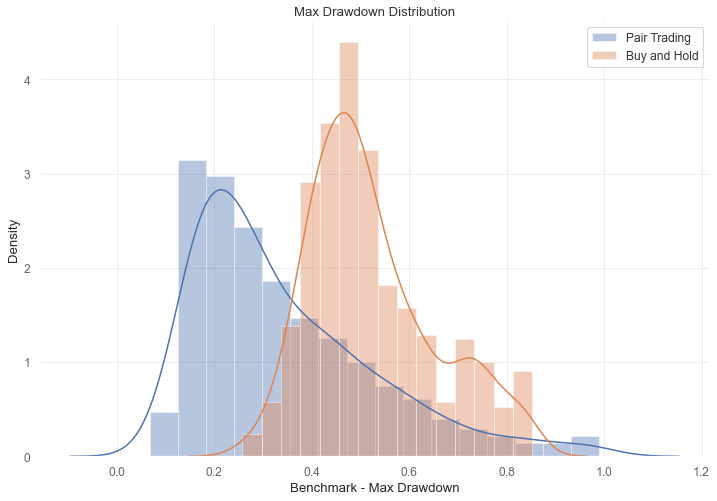

In [24]:
# Plot overlapping histogram
fig, ax = plt.subplots(figsize=(12, 8))
sns.distplot(backtest_result_df.loc[backtest_result_df['Max Drawdown'] < 1, 'Max Drawdown'], label='Pair Trading', ax=ax)
sns.distplot(backtest_result_df['Benchmark - Max Drawdown'], label='Buy and Hold', ax=ax)
ax.legend()
ax.set_title('Max Drawdown Distribution')


In [25]:
backtest_result_df.describe()

,cointegration,cointegration_test_period,correlation,alpha,beta,left_half_life,right_half_life,spread_half_life,left_hurst,right_hurst,left_VaR,left_CVaR,right_VaR,right_CVaR,Total Return,Annualized Return,Annualized Volatility,Max Drawdown,Sharpe Ratio,Calmar Ratio,Sortino Ratio,Benchmark - Total Return,Benchmark - Annualized Return,Benchmark - Annualized Volatility,Benchmark - Max Drawdown,Benchmark - Sharpe Ratio,Benchmark - Calmar Ratio,Benchmark - Sortino Ratio,Total Trade,Win Count,Loss Count,Avg Trade per Year,Win Rate [%],Avg Winning per Trade [%],Avg Losing per Trade [%],Avg Winning Duration [days],Avg Losing Duration [days],Total Trade Duration [days],Avg Trade Duration per Year [days]
count,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,513.000000,528.000000,528.000000,513.000000,513.000000,513.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,526.000000,463.000000,526.000000,463.000000,528.000000,528.000000
mean,0.979475,2447.460227,0.690116,-0.963336,1.107288,-3061.334157,-1850.574736,193.795733,0.445385,0.440340,-0.032421,-0.052401,-0.038909,-0.062904,0.977174,0.094458,3.586699,0.479010,0.469967,0.410195,0.548261,1.250038,0.125890,0.347985,0.523680,0.376236,0.258618,0.499254,11.910985,9.299242,2.611742,1.450140,75.869706,16.586640,-14.607632,127.296578,175.820734,1202.047348,145.776635
std,0.015145,1393.754530,0.440836,6.299120,1.494110,54394.104824,31746.774695,46.135823,0.046071,0.060284,0.008214,0.013674,0.011716,0.017992,2.874295,0.139430,23.213344,0.562392,0.413510,0.417681,0.490411,1.506089,0.109879,0.145290,0.129481,0.300198,0.224068,0.400767,5.489133,5.097665,2.388861,0.667886,19.674250,45.215020,25.242067,143.179220,200.712023,301.449918,35.115112
min,0.950185,1261.000000,-0.891655,-40.717119,-5.073766,-258785.054945,-159222.496791,5.907756,0.322074,0.284337,-0.057787,-0.099096,-0.063710,-0.099496,-8.835614,-0.887427,0.072594,0.068454,-0.659456,-0.533775,-0.594807,-0.668135,-0.172608,0.194607,0.258191,-0.475277,-0.234716,-0.675933,2.000000,0.000000,0.000000,0.237288,0.000000,0.521687,-247.989219,6.000000,0.000000,442.000000,52.440678
25%,0.965083,1562.000000,0.697220,-2.718694,0.538102,-6206.031141,-3881.505928,167.422453,0.410666,0.412496,-0.036243,-0.059934,-0.049326,-0.077726,0.149913,0.037525,0.162229,0.209235,0.159771,0.108537,0.150640,0.347927,0.052626,0.269273,0.431428,0.172891,0.114271,0.245887,8.000000,5.000000,1.000000,0.957596,64.705882,5.590240,-14.842870,60.000000,60.500000,1017.000000,124.448827
50%,0.982253,1914.000000,0.864705,-0.187290,0.912765,-2693.848790,191.304882,203.471590,0.444687,0.440375,-0.030967,-0.050189,-0.038514,-0.059152,0.691705,0.099177,0.208477,0.307980,0.489026,0.356828,0.557688,0.907496,0.121096,0.304103,0.492595,0.353316,0.233355,0.462311,12.000000,9.000000,2.000000,1.471364,80.000000,8.162033,-7.596709,89.000000,116.000000,1167.500000,141.127119
75%,0.993078,2637.500000,0.936183,1.701590,1.456961,2073.189030,1895.309291,231.183892,0.476693,0.477909,-0.026500,-0.042173,-0.028434,-0.048662,1.189911,0.150566,0.311642,0.495456,0.777650,0.659923,0.899705,1.529561,0.179747,0.370890,0.596092,0.593846,0.388454,0.765871,15.000000,12.000000,4.000000,1.898305,90.909091,12.888760,-3.888553,134.000000,195.500000,1339.250000,160.762712
max,0.999987,6248.000000,0.998782,26.164523,10.420919,523508.987917,448488.585642,251.720565,0.560997,0.638368,-0.020013,-0.032029,-0.018923,-0.029135,52.813119,0.983035,381.540961,4.309762,1.840646,2.646378,2.210546,8.514413,0.472535,1.189074,0.852769,1.147403,1.164537,1.623494,42.000000,27.000000,25.000000,4.983051,100.000000,818.658521,-0.024486,1974.000000,1322.000000,2796.000000,331.728814
